# DALLE-Server를 Colab에서 구동하기.

이용하기 쉬운 외부 가상환경인 Colab에서 DALLE-Server를 구동합니다.
Colab 을 상시 서버로 사용하기는 힘들기 때문에 단순히 Test 용도로 쓰는게 좋습니다.

## 필요 파일 설치

서버를 구동하기 위해 필요한 기본 패키지를 Colab 환경에 설치합니다.
의존성 및 안정적인 구동을 고려해 원작자가 추천하는 기본 패키지로 재설치하겠습니다.

In [1]:
!pip install Flask==1.1.2
!pip install Flask-Cors==3.0.9
!pip install Flask-RESTful==0.3.8
!pip install dalle-pytorch==0.14.3
!pip install tqdm
!pip install deepspeed==0.4.2
!pip install triton==0.4.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


위 패키지 외에 외부에서 접근 가능하게 만들기 위해 ngrok 패키지가 필요합니다. ngrok 을 사용하면 Flask app 이 Local host 가 아니라 ngrok 에서 만들어주는 특정한 host 에서 실행됩니다.

In [2]:
!pip install flask-ngrok

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## 패키지 임포트

In [3]:
from flask import Flask, request, jsonify
from flask_ngrok import run_with_ngrok
from tqdm import tqdm
import numpy
from queue import Queue, Empty
from threading import Thread
import time

# torch

import torch

from einops import repeat

# vision imports

from PIL import Image

# dalle related classes and utils

from dalle_pytorch import VQGanVAE, DALLE
from dalle_pytorch.tokenizer import tokenizer

import base64
import os
from io import BytesIO

In [4]:
REQUEST_BATCH_SIZE = 4
PROCESS_IMAGE_CNT = 10
CHECK_INTERVAL = 0.1

REQUEST_ERR_IMAGES_OVER = {'Error': f'Too Many Images requested. Request no more than {PROCESS_IMAGE_CNT}'}
REQUEST_ERR_INVALID = {'Error': 'Invalid Request'}
REQUEST_ERR_GENERATE = {'Error': 'Image Generate Error'}

TEST_INTERNAL_SERVER = '127.0.0.1'
TEST_INTERNAL_PORT = '5000'

## Model 불러오기

VQGAN 의 엔코더를 VAE로 불러옵니다.

In [5]:
# load model

vae = VQGanVAE(None, None)

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
Loaded VQGAN from /root/.cache/dalle/vqgan.1024.model.ckpt and /root/.cache/dalle/vqgan.1024.config.yml


## Checkpoint download

Pretrained 된 값을 가져오기 위해 Checkpoint를 가져오고, 이를 불러옵니다.
참고로 필요한 Checkpoint는 아래 위치에서 참고했습니다.

- model checkpoint : https://github.com/robvanvolt/DALLE-models/tree/main/models/taming_transformer

In [6]:
!wget --no-check-certificate https://www.dropbox.com/s/8mmgnromwoilpfm/16L_64HD_8H_512I_128T_cc12m_cc3m_3E.pt

--2022-09-05 11:19:23--  https://www.dropbox.com/s/8mmgnromwoilpfm/16L_64HD_8H_512I_128T_cc12m_cc3m_3E.pt
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/8mmgnromwoilpfm/16L_64HD_8H_512I_128T_cc12m_cc3m_3E.pt [following]
--2022-09-05 11:19:24--  https://www.dropbox.com/s/raw/8mmgnromwoilpfm/16L_64HD_8H_512I_128T_cc12m_cc3m_3E.pt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc7f20dadc327b681f7b64c138d0.dl.dropboxusercontent.com/cd/0/inline/BsUaIN1a87gMYifdlVI158kxdjqjSbXfFEjeW1-6sC8-XrFyroAzl6R7jlyA2guvQp5kswwSY_x5K1F6dlZQYxdqHg2cW4o0jKc0R9YNTTr7fPYdkYHIfr5IcojwFAUIrc_GzoG2kJ8tXO47PBnABIy9SuVCfIE6j7S6-5QoNH5N0g/file# [following]
--2022-09-05 11:19:24--  https://uc7f20dadc327b681f7b64c138d0.dl.dropboxusercontent.com/cd/0/inline/B

## Image 생성

다운로드 받은 Checkpoint에 맞게 Image를 생성합니다.


In [7]:
def load_model(path: str, device: str):
    model_data = torch.load(path, map_location=device)
    # clean-up the VAE model for using VQGan at this model
    dalle_params, _, weights = model_data.pop('hparams'), model_data.pop('vae_params'), model_data.pop('weights')
    dalle_params.pop('vae', None)
    # load the VAE
    vae = VQGanVAE(None, None)
    # load the DALLE
    model = DALLE(vae=vae, **dalle_params).cuda()
    model.load_state_dict(weights)
    return model

def generate(text,
             num_images,
             model_path: str,
             batch_size=4,
             thresh=0.9):
    if torch.cuda.is_available():
        device = 'cuda'
    else:
        device = 'cpu'
    try:
        # load the DALLE model
        dalle = load_model(model_path, device=device)
        # tokenize the input texts
        text_token = tokenizer.tokenize([text], dalle.text_seq_len).to(device)
        text_token = repeat(text_token, '() n -> b n', b=num_images)
        res, outputs = [], []
        for x in tqdm(text_token.split(batch_size), desc=f'generating images for - {text_token}'):
            # generate the image with input tokens
            y = dalle.generate_images(x, filter_thres=thresh)
            outputs.append(y)
        outputs = torch.cat(outputs)
        for i, y in tqdm(enumerate(outputs), desc='saving images'):
            # convert the output to the image with 8bit scales
            y = numpy.moveaxis(y.detach().cpu().numpy(), 0, -1)
            y = (y * 255).astype('uint8')
            image = Image.fromarray(y)
            # encode the image to the string for the request POST
            buffered = BytesIO()
            image.save(buffered, format='JPEG')
            img_encode = base64.b64encode(buffered.getvalue()).decode('utf-8')
            res.append(img_encode)
        return res
    except Exception as ex:
        print('Error occur in script generating!', ex)
        return ex

## Flask 블루 프린트 구성

생성된 Image를 Flask와 REST로 보낼 수 있는 router를 구성합니다.

In [8]:
def create_app(dalle_path: str):
    app = Flask(__name__)
    run_with_ngrok(app)
    if not os.path.exists(dalle_path):
        raise ReferenceError(f"DALL-E Model ({dalle_path}) is not exists")

    @app.route('/dalle', methods=['POST'])
    def generate_dalle():
        try:
            json_data = request.get_json()
            text, num_images = json_data['text'], json_data['num_images']
            if num_images > 10:
                return jsonify(REQUEST_ERR_IMAGES_OVER), 500
            res = generate(text, num_images, model_path=dalle_path)
            if not isinstance(res, list):
                return jsonify(REQUEST_ERR_GENERATE), 500
            else:
                return jsonify(res), 200
        except:
            return jsonify(REQUEST_ERR_INVALID), 500

    @app.route('/health', methods=['GET'])
    def check_health():
        return "OK", 200

    @app.route('/images/<param>', methods=['GET'])
    def get_images():
        pass

    return app

## Server 실행

Flask 명령으로 서버를 실행합니다.


In [9]:
app = create_app(dalle_path='16L_64HD_8H_512I_128T_cc12m_cc3m_3E.pt')
server = Thread(target=app.run)
server.start()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


---
## Client 구성

Colab 내 Test 를 위해 Client를 구성합니다. Client로 먼저 주어진 host 주소에 health 체크 명령을 보냅니다.

In [11]:
import requests

HOST_SERVER = 'http://127.0.0.1:5000'
res = requests.get(HOST_SERVER + '/health')
print(res.content)


INFO:werkzeug:127.0.0.1 - - [05/Sep/2022 11:20:32] "GET /health HTTP/1.1" 200 -


b'OK'


## Client → Server 요청

Client 를 통해 Image 생성 명령을 보내고, 결과를 받습니다.

- num_images : 생성할 추정 Image 갯수 `(Max=10)`
- text : 컨버팅 해야할 글자

예시의 입력 문자는 'Happy dog' 이지만, 마음대로 바꿔도 됩니다. 

In [12]:
data = {'num_images': 5, 'text': 'smiling woman'}
res = requests.post(HOST_SERVER + '/dalle', json=data)

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
Loaded VQGAN from /root/.cache/dalle/vqgan.1024.model.ckpt and /root/.cache/dalle/vqgan.1024.config.yml


generating images for - tensor([[9200, 2308,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0],
        [9200, 2308,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0, 

Using /root/.cache/torch_extensions/py37_cu113 as PyTorch extensions root...
Emitting ninja build file /root/.cache/torch_extensions/py37_cu113/sparse_attn/build.ninja...
Building extension module sparse_attn...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
Loading extension module sparse_attn...
Time to load sparse_attn op: 0.417072057723999 seconds


/usr/local/lib/python3.7/dist-packages/triton/kernel.py:37: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  return (a + b - 1) // b
/usr/local/lib/python3.7/dist-packages/deepspeed/ops/sparse_attention/matmul.py:44: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  div = sizes // seg_max
generating images for - tensor([[9200, 2308,    0,   

이상없이 서버가 동작하면 아래와 같은 base64 형식의 인코딩 텍스트가 나타납니다.

In [13]:
print(res.content)

b'["/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAEAAQADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD2sU4CjFOFZiAVKnWo6lSqAlWn00U6mMKKKKBi0hpaSgBDXlvxM/ea7p8XXbET+tepGvMPGg+0eNoY+oSFf5k1x492o/NHTg1+9v2TOE8ZxhtHWMAnYVJzVHR4gbpFA6jmuj8W2YOkXBAy23j8Oa5zSZDb69scfKyAgfhX

## 디코딩

Base64 로 인코딩된 결과값을 디코딩해서 출력해봅니다.

In [14]:
img_encodes = res.json()
print(img_encodes)

['/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAEAAQADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD2sU4CjFOFZiAVKnWo6lSqAlWn00U6mMKKKKBi0hpaSgBDXlvxM/ea7p8XXbET+tepGvMPGg+0eNoY+oSFf5k1x492o/NHTg1+9v2TOE8ZxhtHWMAnYVJzVHR4gbpFA6jmuj8W2YOkXBAy23j8Oa5zSZDb69scfKyAgfhXI4

=> Receive(0) : /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAEAAQADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD2sU4CjFOFZiAVKnWo6lSqAlWn00U6mMKKKKBi0hpaSgBDXlvxM/ea7p8XXbET+tepGvMPGg+0eNoY+oSFf5k1x492o/NHTg1+9v2TOE8ZxhtHWMAnYVJzVHR4gbpFA6jmuj8W2YOkXBAy23j8Oa5zSZDb

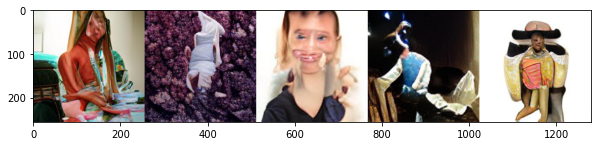

In [15]:
import matplotlib.pyplot as plt

imgs = []
for i, img_str in enumerate(img_encodes):
  print(f'=> Receive({i}) : {img_str}')
  imgs.append(Image.open(BytesIO(base64.b64decode(img_str))))
imgs = numpy.concatenate(imgs, axis=1)

plt.figure(figsize=(10, 50))
plt.imshow(imgs)